In [1]:
import json
import csv
from pprint import pprint
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize

In [2]:
path = '/Users/stylshreyeshi/Desktop/location.json'
with open(path) as f:
    data = json.load(f)

In [3]:
df = pd.DataFrame.from_dict(data, orient='columns')
df.head()

,locations
0,"{'timestampMs': '1543320317919', 'latitudeE7':..."
1,"{'timestampMs': '1543319700075', 'latitudeE7':..."
2,"{'timestampMs': '1543319641689', 'latitudeE7':..."
3,"{'timestampMs': '1543319100119', 'latitudeE7':..."
4,"{'timestampMs': '1543318465263', 'latitudeE7':..."


In [4]:
df = pd.read_json((df['locations']).to_json(), orient='index')
df.head()

,accuracy,activity,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy
0,24,NaN,NaN,NaN,284199428,770382287,2018-11-27 12:05:17.919,NaN,NaN
1,24,NaN,NaN,NaN,284199504,770382172,2018-11-27 11:55:00.075,NaN,NaN
2,23,NaN,NaN,NaN,284199471,770381858,2018-11-27 11:54:01.689,NaN,NaN
3,22,"[{'timestampMs': '1543318824627', 'activity': ...",NaN,NaN,284199504,770382163,2018-11-27 11:45:00.119,NaN,NaN
4,24,NaN,NaN,NaN,284199119,770381655,2018-11-27 11:34:25.263,NaN,NaN


In [5]:
df['activity'].fillna(value='-',inplace=True)
df['activity'] = df['activity'].apply(lambda x: "".join(map(str,x)) )

In [6]:
df['activity_timestampMs'] = df['activity'].apply(lambda x: x[x.find('timestampMs')+15:30])
df['activity_data'] = df['activity'].apply(lambda x: x[x.find('activity')+22:x.find('confidence')-4])
df['confidence'] = df['activity'].apply(lambda x: x[x.find('confidence')+13:x.find('}')])
df.head()

,accuracy,activity,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy,activity_timestampMs,activity_data,confidence
0,24,-,NaN,NaN,284199428,770382287,2018-11-27 12:05:17.919,NaN,NaN,,,
1,24,-,NaN,NaN,284199504,770382172,2018-11-27 11:55:00.075,NaN,NaN,,,
2,23,-,NaN,NaN,284199471,770381858,2018-11-27 11:54:01.689,NaN,NaN,,,
3,22,"{'timestampMs': '1543318824627', 'activity': [...",NaN,NaN,284199504,770382163,2018-11-27 11:45:00.119,NaN,NaN,1543318824627,STILL,52
4,24,-,NaN,NaN,284199119,770381655,2018-11-27 11:34:25.263,NaN,NaN,,,


In [7]:
from datetime import datetime
df['activity_timestampMs'] = np.where(df['activity_timestampMs']=='',0,pd.to_numeric(df['activity_timestampMs']))
df['activity_timestampMs'] = df['activity_timestampMs'].apply(lambda x: datetime.utcfromtimestamp(int(x/1000)).strftime('%Y-%m-%d %H:%M:%S'))

In [8]:
df['latitudeE7'] = df['latitudeE7'].apply(lambda x: int(x)/10000000)
df['longitudeE7'] = df['longitudeE7'].apply(lambda x: int(x)/10000000)

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, polygon
%matplotlib inline
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitudeE7, df.latitudeE7))
gdf.head()

,accuracy,activity,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy,activity_timestampMs,activity_data,confidence,geometry
0,24,-,NaN,NaN,28.419943,77.038229,2018-11-27 12:05:17.919,NaN,NaN,1970-01-01 00:00:00,,,POINT (77.0382287 28.4199428)
1,24,-,NaN,NaN,28.419950,77.038217,2018-11-27 11:55:00.075,NaN,NaN,1970-01-01 00:00:00,,,POINT (77.03821720000001 28.4199504)
2,23,-,NaN,NaN,28.419947,77.038186,2018-11-27 11:54:01.689,NaN,NaN,1970-01-01 00:00:00,,,POINT (77.03818579999999 28.4199471)
3,22,"{'timestampMs': '1543318824627', 'activity': [...",NaN,NaN,28.419950,77.038216,2018-11-27 11:45:00.119,NaN,NaN,2018-11-27 11:40:24,STILL,52,POINT (77.0382163 28.4199504)
4,24,-,NaN,NaN,28.419912,77.038166,2018-11-27 11:34:25.263,NaN,NaN,1970-01-01 00:00:00,,,POINT (77.03816550000001 28.4199119)


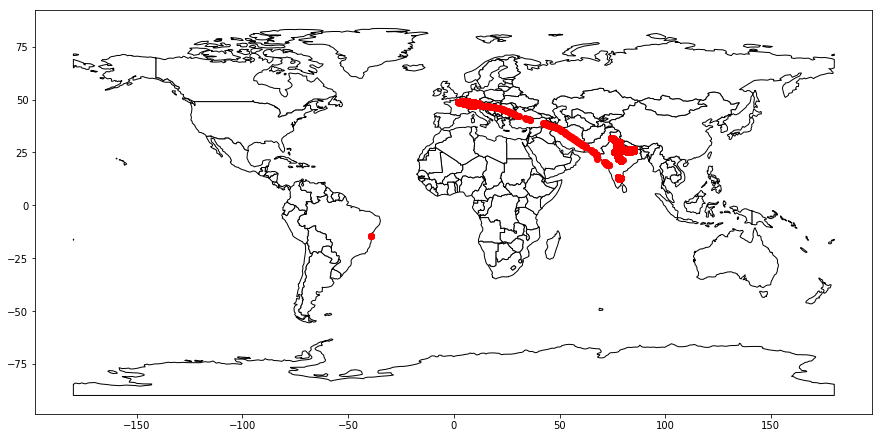

In [10]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
gdf.plot(ax=ax, color='red')
plt.show()

In [11]:
import folium
from folium import plugins
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [60]:
m = folium.Map([28.48, 77.07], zoom_start=12)
df1 = df[(df['timestampMs'].dt.year==2018) & (df['timestampMs'].dt.month==4) & (df['timestampMs'].dt.day<6)]
for index, row in df1.iterrows():
    folium.CircleMarker([row['latitudeE7'], row['longitudeE7']],
                        radius=0.0001,
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m)
point_ = df1[['latitudeE7', 'longitudeE7']].as_matrix()
m.add_child(plugins.HeatMap(point_, radius=15))
m

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [13]:
df.head()

,accuracy,activity,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy,activity_timestampMs,activity_data,confidence,geometry
0,24,-,NaN,NaN,28.419943,77.038229,2018-11-27 12:05:17.919,NaN,NaN,1970-01-01 00:00:00,,,POINT (77.0382287 28.4199428)
1,24,-,NaN,NaN,28.419950,77.038217,2018-11-27 11:55:00.075,NaN,NaN,1970-01-01 00:00:00,,,POINT (77.03821720000001 28.4199504)
2,23,-,NaN,NaN,28.419947,77.038186,2018-11-27 11:54:01.689,NaN,NaN,1970-01-01 00:00:00,,,POINT (77.03818579999999 28.4199471)
3,22,"{'timestampMs': '1543318824627', 'activity': [...",NaN,NaN,28.419950,77.038216,2018-11-27 11:45:00.119,NaN,NaN,2018-11-27 11:40:24,STILL,52,POINT (77.0382163 28.4199504)
4,24,-,NaN,NaN,28.419912,77.038166,2018-11-27 11:34:25.263,NaN,NaN,1970-01-01 00:00:00,,,POINT (77.03816550000001 28.4199119)


In [34]:
import reverse_geocoder as rg 
def reverseGeocode(coordinates): 
    result = ((rg.search(coordinates))[0])['name'] 
    #z = result[0]
    return result #(z['name'])
reverseGeocode((28.419943,77.038229))

'Gurgaon'

In [35]:
df2 = df.copy()
df2['coordinates'] = list(zip(df2.latitudeE7, df2.longitudeE7))

In [36]:
df2 = df2.sample(n=1000)

In [38]:
#df2 = df2 
start = datetime.now()
print('Started at:' + str(start))    
df2['City'] = df2['coordinates'].apply(lambda x: ((rg.search(x))[0])['name']) #((rg.search(x))[0])['name'])
end = datetime.now()
print('\nEnd at:' + str(end))    
print('\nDiff:' + str(end-start))

268 µs ± 2.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Started at:2019-06-10 15:37:53.290558

End at:2019-06-10 15:42:14.185016

Diff:0:04:20.894458


In [47]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='sshreyeshi@gmail.com')
location = geolocator.reverse("28.419943,77.038229")
location

Location(HDFC Bank, Sohna Road, Sector 33, Gurugram, Haryana, 122012, India, (28.4196494, 77.0380698, 0.0))

In [59]:
df3=df.copy()
df3=df3.sample(n=1000)
import pandas as pd, requests
df3['geocode_data'] = ''
df3['city'] = ''
df3['country'] = ''
def reverse_geocode(latlng):
    result = {}
    url = 'https://maps.googleapis.com/maps/api/geocode/json?latlng={}'
    request = url.format(latlng)
    data = requests.get(request).json()
    if len(data['results']) > 0:
        result = data['results'][0]
    return result

df3['latlng'] = (df3['latitudeE7'].map(str) + ',' + df3['longitudeE7'].map(str))

print('Find Geocode Data: \nStart at:'+str(datetime.now()))
df3['geocode_data'] = df3['latlng'].map(reverse_geocode)
print('Find Geocode Data: \End at:'+str(datetime.now()))

def parse_country(geocode_data):
    if (not geocode_data is None) and ('address_components' in geocode_data):
        for component in geocode_data['address_components']:
            if 'country' in component['types']:
                return component['long_name']
    return None
 
def parse_city(geocode_data):
    if (not geocode_data is None) and ('address_components' in geocode_data):
        for component in geocode_data['address_components']:
            if 'locality' in component['types']:
                return component['long_name']
            elif 'postal_town' in component['types']:
                return component['long_name']
            elif 'administrative_area_level_2' in component['types']:
                return component['long_name']
            elif 'administrative_area_level_1' in component['types']:
                return component['long_name']
    return None

print('Find City/Country: \nStart at:'+str(datetime.now()))
df3['city'] = df3['geocode_data'].map(parse_city)
df3['country'] = df3['geocode_data'].map(parse_country)
print('Find City/Country: \End at:'+str(datetime.now()))
df3.head()

Find Geocode Data: 
Start at:2019-06-10 16:17:50.925755
Find Geocode Data: \End at:2019-06-10 16:21:30.800075
Find City/Country: 
Start at:2019-06-10 16:21:30.800739
Find City/Country: \End at:2019-06-10 16:21:30.803767


,accuracy,activity,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy,activity_timestampMs,activity_data,confidence,geometry,geocode_data,city,country,latlng
206054,23,"{'timestampMs': '1506429322823', 'activity': [...",NaN,NaN,28.414715,77.044944,2017-09-26 12:34:11.477,NaN,NaN,2017-09-26 12:35:22,STILL,100,POINT (77.04494390000001 28.4147149),{},None,None,"28.4147149,77.0449439"
8083,33,"{'timestampMs': '1541533800059', 'activity': [...",NaN,NaN,28.414490,77.045092,2018-11-06 19:50:00.071,NaN,NaN,2018-11-06 19:50:00,STILL,65,POINT (77.0450924 28.4144901),{},None,None,"28.4144901,77.0450924"
61943,73,"{'timestampMs': '1530630286683', 'activity': [...",NaN,NaN,28.449299,77.098429,2018-07-03 15:05:00.082,NaN,NaN,2018-07-03 15:04:46,UNKNOWN,31,POINT (77.0984291 28.4492993),{},None,None,"28.4492993,77.0984291"
9772,22,"{'timestampMs': '1541197507425', 'activity': [...",NaN,NaN,28.414516,77.045087,2018-11-02 22:25:19.573,NaN,NaN,2018-11-02 22:25:07,UNKNOWN,25,POINT (77.0450872 28.4145157),{},None,None,"28.4145157,77.0450872"
296512,23,"{'timestampMs': '1494482127811', 'activity': [...",NaN,NaN,28.446601,77.040525,2017-05-11 05:55:28.602,NaN,NaN,2017-05-11 05:55:27,STILL,100,POINT (77.0405248 28.446601),{},None,None,"28.446601,77.0405248"
